In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import datetime as dt

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Wine Reviews - Wine Classifier

Using a set of WineEnthusiast reviews from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews/data), we attempt to classify the wine (variety) based on descriptors (a process akin to a blind tasting) using KNN. 

### Data Cleaning

We start by loading the dataset and taking a look at its first rows:

In [2]:
wine_OG = pd.read_csv(r"winemag-data-130k-v2.csv")

In [3]:
wine_OG.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
wine_OG.shape

(129971, 14)

In [5]:
wine_OG.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

The first thing we notice is that some of these columns are useless for our purposes: `unnamed`(an alternative index for the DF), `region_1`, `region_2`, `taster_name`, `taster_twitter_handle`. We select them out of the DataFrame.

In [6]:
wine = wine_OG[['country', 'description', 'designation', 'points',
       'price', 'province', 'title', 'variety', 'winery']]

The second thing to notice are the missing values. We are particularly interested in points and price, so we will exclude all observations with missing values. The dataset is pretty big, so we can afford to do that and still have plenty (85, 000+) of observations remaining.

In [7]:
wine = wine.dropna()

In [8]:
wine.shape

(86148, 9)

In [9]:
wine.head(3)

,country,description,designation,points,price,province,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Next, we check that all columns of are of the right type. This is the case for this dataset, so no changes are to be made.

In [10]:
wine.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
title           object
variety         object
winery          object
dtype: object

### Description-Based Classification

#### Variable Selection

I already explored the dataset in a different notebook. To simplify the dataset, I start off with American wines only.

In [11]:
usa = wine[wine["country"] == "US"]

In [12]:
usa.shape

(36751, 9)

In [13]:
usa.head(3)

,country,description,designation,points,price,province,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


The descriptor-based approach I'm proposing requires only the wine's description and variety, so I select an even smaller copy of the dataframe.

In [14]:
tasting_us = usa[["variety", "description"]]

I then create a vocabular list of wine descriptors, selected from the [list linked here](https://www.jancisrobinson.com/learn/vocabulary/tasting-terms). Someone with more knowledge of wine terminology could greatly add to this, either by providing other commonly used descriptors or helping group them together.

In [15]:
descriptors = ''' Acetic
Aroma
Astringent
Balanced
Concentrated 
Crisp 
Firm
Flabby
Fresh
Green
Hard
Hot
Lean
Light
Mellow
Powerful
Rich
Round
Soft
Supple
Tannic
Tart
Volatile '''
descriptors = descriptors.lower().split()

The code below is a look which creates a new column (a dummy) equal true if the description of the wine contains those descriptors.

In [16]:
tasting_us["description"] = tasting_us["description"].str.replace(",", " ").replace(".", " ").str.lower() #cleaning up the strings

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
for i in descriptors:
    tasting_us[i] = tasting_us["description"].str.contains(i) * 1 #*1 converts the True, False into 1, 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
tasting_us.head(3)

,variety,description,acetic,aroma,astringent,balanced,concentrated,crisp,firm,flabby,...,light,mellow,powerful,rich,round,soft,supple,tannic,tart,volatile
3,Riesling,pineapple rind lemon pith and orange blossom ...,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,Pinot Noir,much like the regular bottling from 2012 this...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,Cabernet Sauvignon,soft supple plum envelopes an oaky structure ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


Finally, to make it easier for our model, I select the 10 most common varieties. These varieties account for 76.24% of all reviews so, again, we should be fine observation-wise.

In [19]:
tasting_us["variety"].value_counts().head(10).index

Index(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Syrah',
       'Zinfandel', 'Bordeaux-style Red Blend', 'Riesling', 'Merlot',
       'Sauvignon Blanc'],
      dtype='object')

In [20]:
tasting_us["variety"].value_counts().head(10).sum() / tasting_us["variety"].value_counts().sum()

0.7624010231014122

In [21]:
tasting_us = tasting_us.loc[tasting_us['variety'].isin(tasting_us["variety"].value_counts().head(10).index)]

In [22]:
tasting_us.shape

(28019, 25)

#### K-Nearest Neighbors

We use KNN to classify the wines into one of these 10 varieties, based on our descriptors.

In [28]:
x = np.array(tasting_us.iloc[:, 2:])# split into predictors and response, selects all columns after variety + description
y = np.array(tasting_us.iloc[:, 0]) #selects the response y

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)# split into train and test

scores = []

for i in range(1, 50): #runs loop with different numbers of k
    knn = KNeighborsClassifier(n_neighbors = i)# instantiate learning model (k = i)
    knn.fit(x_train, y_train) # fitting the model
    pred = knn.predict(x_test)# predict the response
    scores.append(sklearn.metrics.accuracy_score(y_test, pred)) # evaluate accuracy

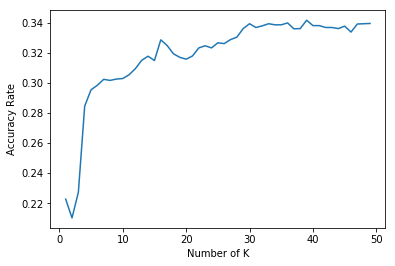

In [30]:
fig, ax = plt.subplots()
ax.plot(range(1, 50), scores)
ax.set_ylabel("Accuracy Rate")
ax.set_xlabel("Number of K");

In [31]:
max(scores)

0.34154175588865099

In [32]:
sum(pred == y_test) / len(pred) #correct

0.33940042826552463

KNN has a mediocre performance here: the best KNN approximator has a **34** % accuracy rate. Another model with *more* varieties fared worse, with a 25% accuracy rate. To be fair, descriptors are very subjective and may not be sufficient to identify wine varieties (as opposed to maybe simply classifying wines as red/white). 

#### Guesstimate

For the sake of comparison, we implement a simple rule-of-thumb for guessing varieties for tastings:
- what color is it? (red or white)
- guess the variety based on the weights of most common varieties of its type (red/white)

Unlike the computer machine-learning method, this fictional testing isn't blind and the color of the wine is taken into account.

The very simplest version of this rule (guessing Chardonnay for every white wine and Pinot Noir for every red wine) outperforms all others *and* our KNN classifier... 

In [34]:
red = ['Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Syrah',
       'Zinfandel', 'Bordeaux-style Red Blend',  'Merlot']
white = ['Chardonnay', 'Riesling', 'Sauvignon Blanc']

In [35]:
guess = []

for i in y_test:
    if i in white:
        guess.append("Chardonnay")
    else:
        guess.append("Pinot Noir")
        
sum(guess == y_test) / len(guess)

0.42273376159885795

The lesson here is that simpler can be (much) better. (We could also try to develop rule-of-thumb rules like the above for descriptors, but this is likely more useful for dinner parties etc).

### Lessons/Conjectures

- descriptors likely vary quite a bit depending on the reviewer. Ideally, we would control for individual reviewers.
- there may also be overlap -- we could group descriptors with similar meaning  
- descriptors are a vague/subjective criteria (especially in reviews!!), so not the best predictors 

### Future Steps?
- modifying the classifier so it classifies wines into red/white based on description (limited usefulness) 
- a point estimator that reads in information about the wine and assigns it points